In [53]:
import pandas as pd 
from fbprophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import statsmodels.tsa.seasonal
%config InlineBackend.figure_format = 'retina'

on travaille sur le jeu de donnees qui contient la consommation de l'électricité de la russie , c'est bien le jeu de donneé qui permet d'avoir un grand nombre de donnée pour l'entrainement.

In [54]:
# on ouvre le jeu de données et on garde que les 2 colonnes qui contient la consommation et les dates.
df= pd.read_csv('RU_Electricity_Market_PZ_dayahead_price_volume.csv')
df=df[['timestep','consumption_eur']]
df.head()

,timestep,consumption_eur
0,2006-09-01 00:00,62341.0
1,2006-09-01 01:00,60625.0
2,2006-09-01 02:00,59685.0
3,2006-09-01 03:00,59500.0
4,2006-09-01 04:00,60617.0


In [55]:
# on renome les 2 colonnes par ds pour le temps et y pour la consommation sinon le prophéte marche pas !!
data=df.rename(columns={'timestep': 'ds','consumption_eur':'y'})
data.head()

,ds,y
0,2006-09-01 00:00,62341.0
1,2006-09-01 01:00,60625.0
2,2006-09-01 02:00,59685.0
3,2006-09-01 03:00,59500.0
4,2006-09-01 04:00,60617.0


In [56]:
# on récupére 70% des données pour l'apprentissage et on laisse 30% pour le test
train_size=int(len(data)*0.7)
train=data[:train_size]
test=data[train_size:]

#on crée un data frame qui contient les dates des jours fériers, on se contente du noel et de la fin d'année
Noel= pd.DataFrame({
  'holiday': 'Noel',
  'ds': pd.to_datetime(['2006-12-25', '2007-12-25', '2008-12-25','2009-12-25']),
  'lower_window': 0,
  'upper_window': 2,
})
Fin_annee = pd.DataFrame({
  'holiday': 'Fin d année',
  'ds': pd.to_datetime(['2006-12-31', '2007-12-31', '2008-12-31','2009-12-31']),
  'lower_window': 0,
  'upper_window': 2,
})
vacances = pd.concat((Noel,Fin_annee))
vacances

,holiday,ds,lower_window,upper_window
0,Noel,2006-12-25,0,2
1,Noel,2007-12-25,0,2
2,Noel,2008-12-25,0,2
3,Noel,2009-12-25,0,2
0,Fin d année,2006-12-31,0,2
1,Fin d année,2007-12-31,0,2
2,Fin d année,2008-12-31,0,2
3,Fin d année,2009-12-31,0,2


In [57]:
#on ajuste le modéle, par défaut le modéle est additive. 
model =Prophet(holidays=vacances)
model.fit(train)

In [58]:
#essayons de prédire la consomation pour les 30 jours suivant c-a-d 720h

#on définit le nombre de période au quelle on veut faire de la prédiction et on précise la fréquence:
future = model.make_future_dataframe(periods=720, freq='H')

#on applique le modéle:
forecast = model.predict(future)

forecast est un tableau qui contient des informations en détaille sur la prédiction. Il donne la valeur de la tendance à chaque instant en plus que les valeurs min max estimés à cet instant. 
La valeur prédite pour la consommation est dans la dérniére colonne 'yhat'.
NB: forecast contient aussi les valeurs avec laquelle le modéle est ajusté.

In [59]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Fin d année,Fin d année_lower,Fin d année_upper,Noel,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2006-09-01 00:00:00,78578.323477,59105.313841,65921.768163,78578.323477,78578.323477,0.0,0.0,0.0,0.0,...,1495.229608,1495.229608,1495.229608,-11342.715177,-11342.715177,-11342.715177,0.0,0.0,0.0,62450.485811
1,2006-09-01 01:00:00,78582.930887,57052.516053,63886.508778,78582.930887,78582.930887,0.0,0.0,0.0,0.0,...,1493.016265,1493.016265,1493.016265,-11334.627497,-11334.627497,-11334.627497,0.0,0.0,0.0,60608.583453
2,2006-09-01 02:00:00,78587.538297,56296.820576,63403.834078,78587.538297,78587.538297,0.0,0.0,0.0,0.0,...,1489.534319,1489.534319,1489.534319,-11326.533340,-11326.533340,-11326.533340,0.0,0.0,0.0,59744.715775
3,2006-09-01 03:00:00,78592.145707,56320.383745,63155.802009,78592.145707,78592.145707,0.0,0.0,0.0,0.0,...,1484.182004,1484.182004,1484.182004,-11318.432755,-11318.432755,-11318.432755,0.0,0.0,0.0,59652.827734
4,2006-09-01 04:00:00,78596.753117,57059.177377,63779.929983,78596.753117,78596.753117,0.0,0.0,0.0,0.0,...,1476.317759,1476.317759,1476.317759,-11310.325790,-11310.325790,-11310.325790,0.0,0.0,0.0,60340.796156


In [60]:
#on récupére que les valeurs de la consomation 'yhat' pour les comparer avec les valeurs de test.
Prediction=forecast[['yhat']].values[train_size:]
reel=test[['y']].values[:720]
#les valeurs qu'on vient de récupérer sont nd-array

#transformer nd-array en array
Prediction=np.ravel(Prediction)
reels=np.ravel(reel)

#Mettre les données sous forme serie temporelles pour les visualiser
Predictions=pd.Series(Prediction,index=pd.date_range('2010-04-29 07:00',periods=720,freq='h'))
Real=pd.Series(reels,index=pd.date_range('2010-04-29 07:00',periods=720,freq='h'))

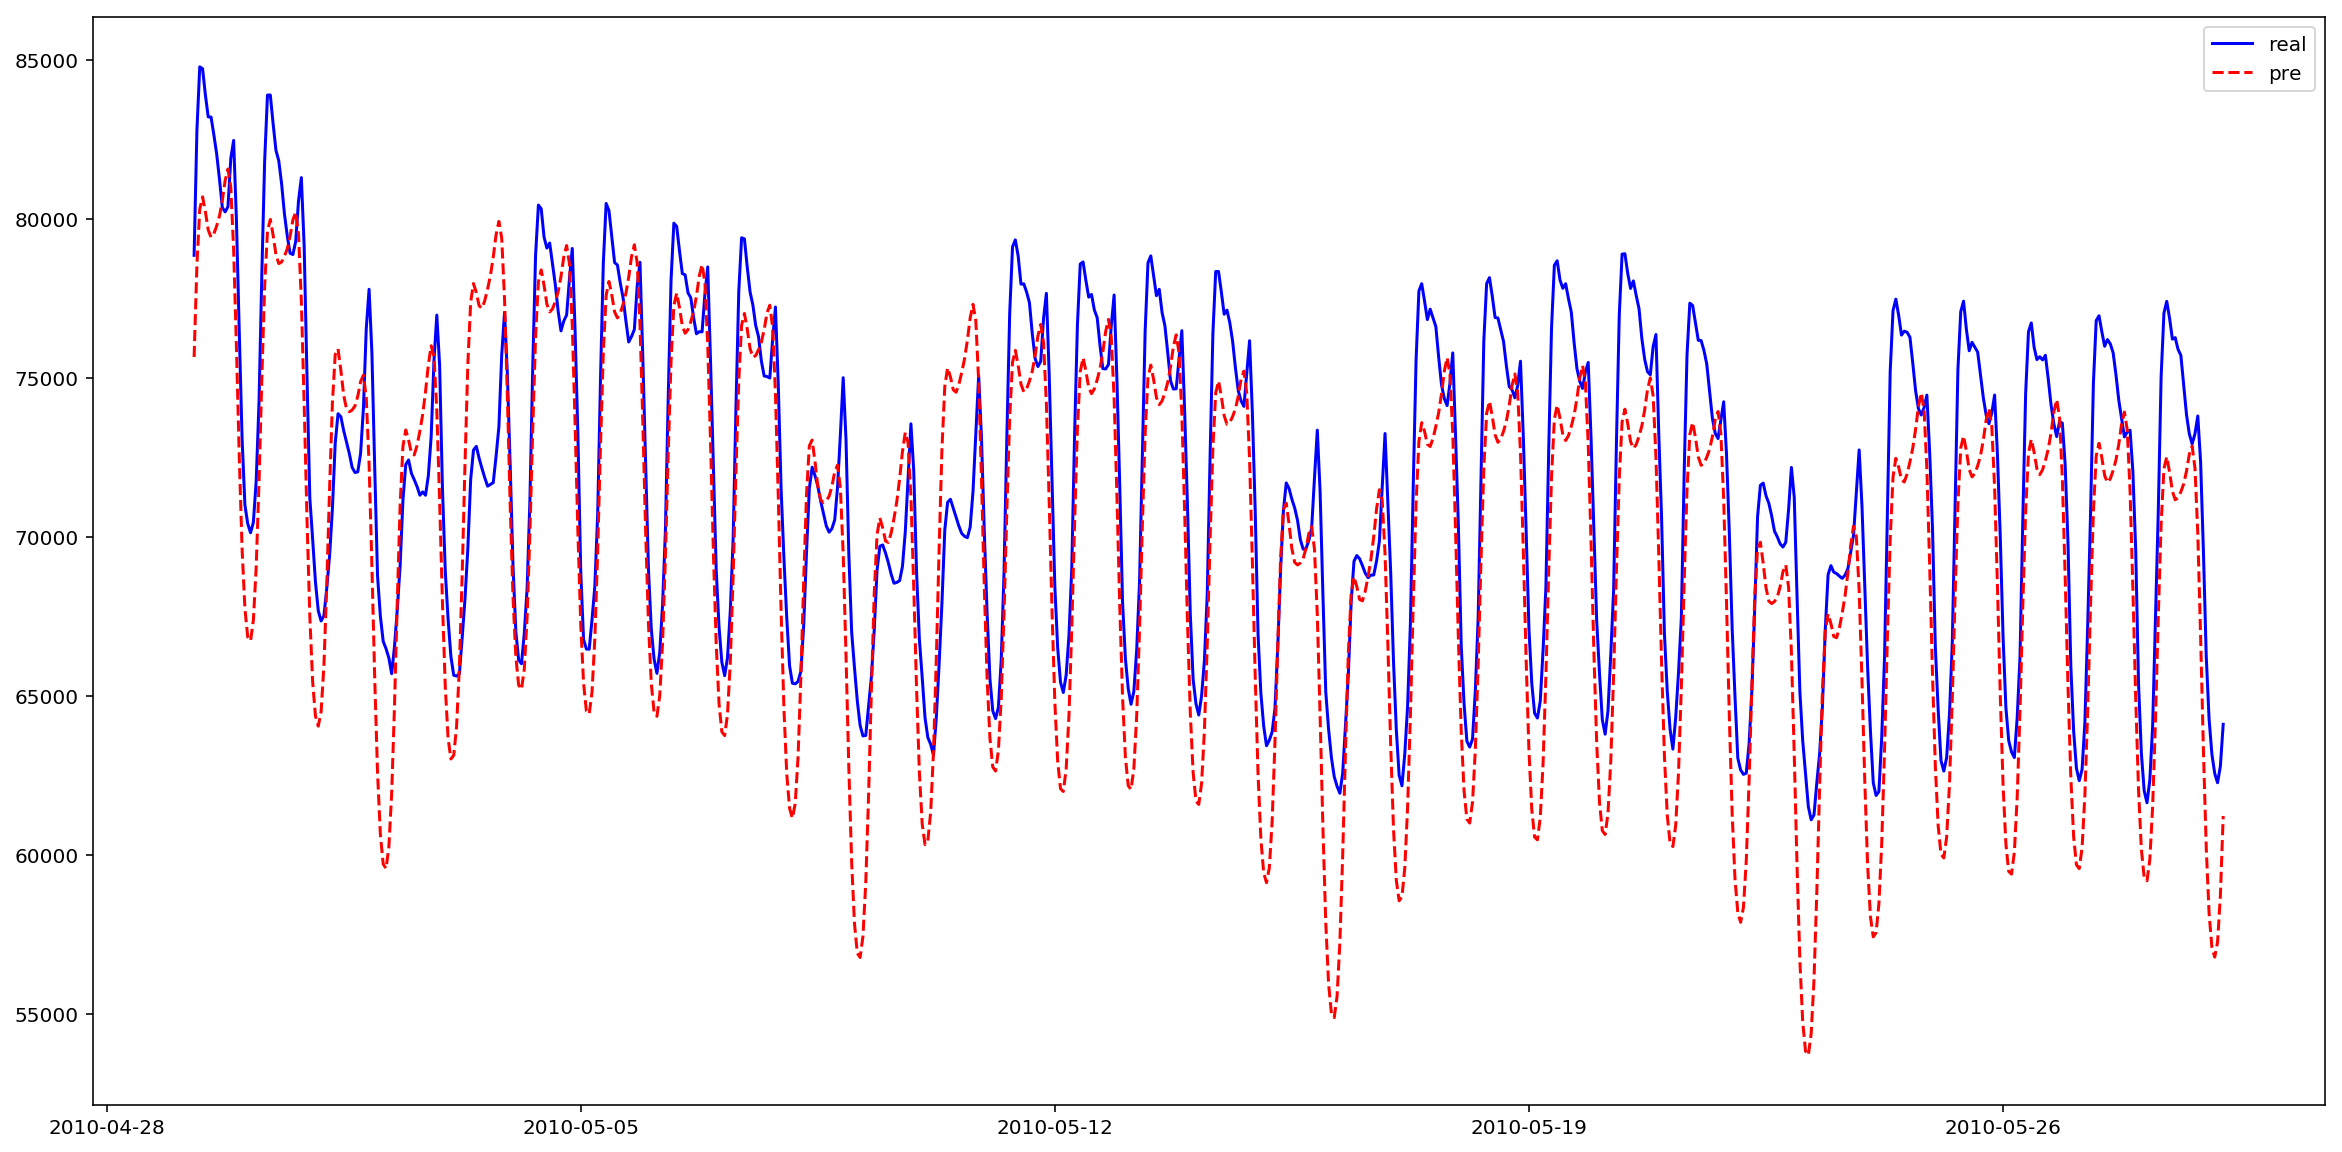

In [64]:

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(Real, '-b', label='real')
ax.plot(Predictions, '--r', label='pre')

leg = ax.legend();

In [77]:
#cette valeur n'a pas de sens que si on la compare avec le résultat d'autres algorithmes:
from sklearn.metrics import mean_squared_error
mean_squared_error(Real,Predictions )

5361.232684769787

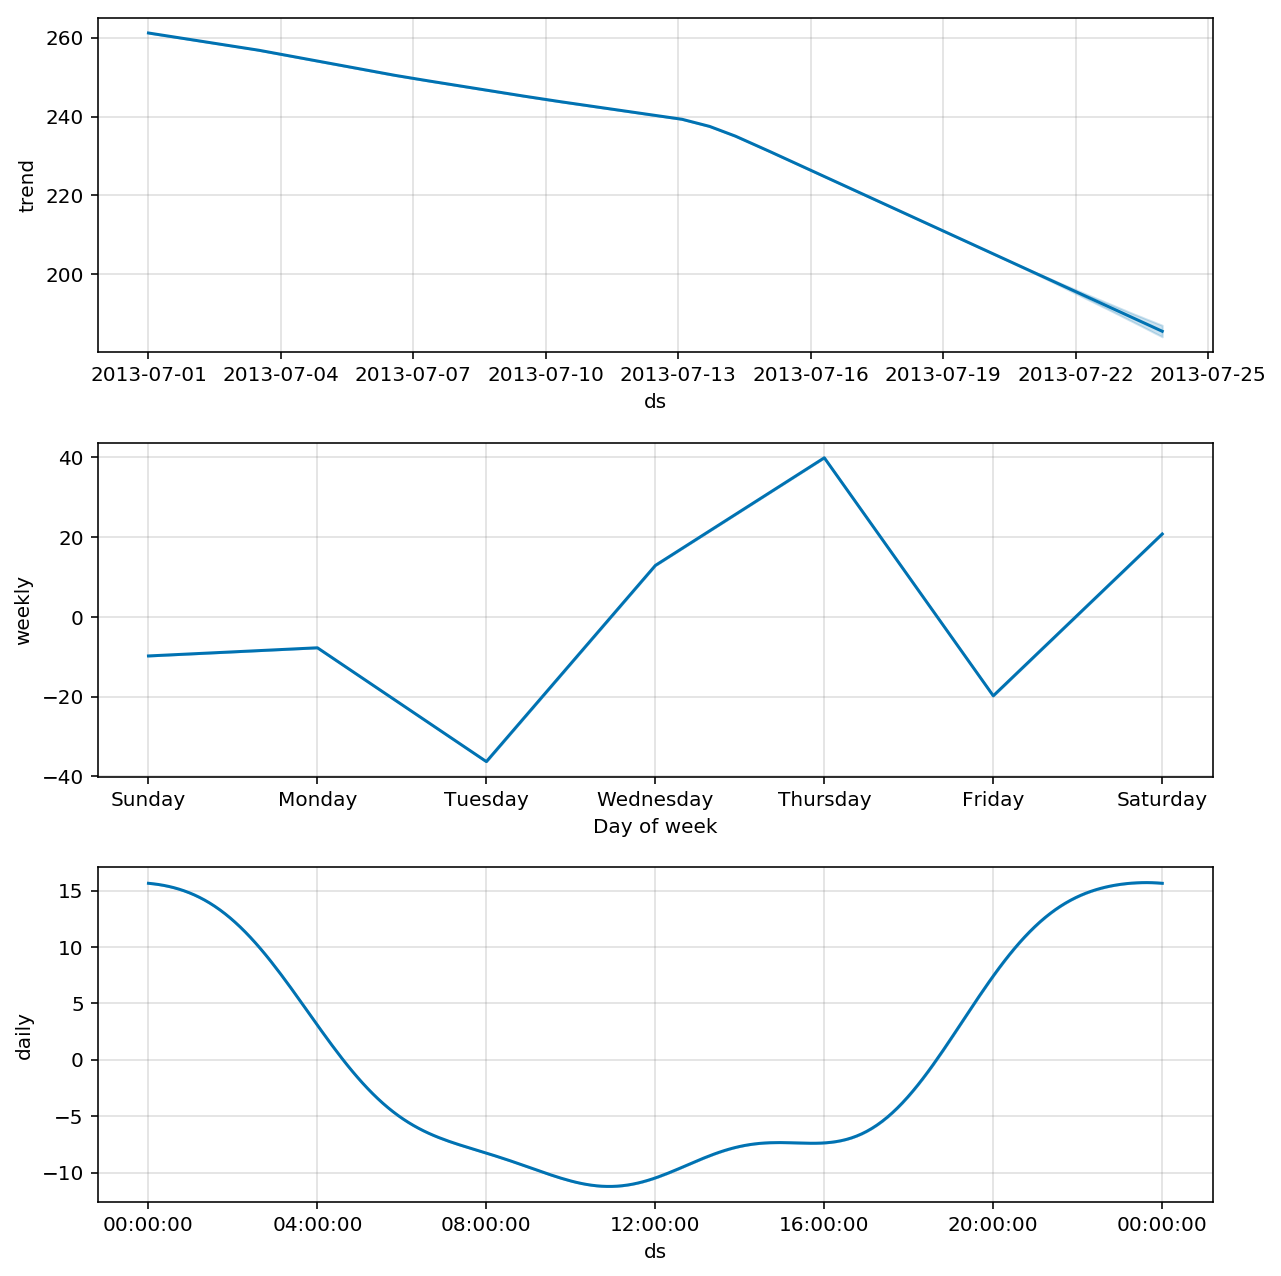

In [79]:
# on visualise les différentes composantes de notre modéle
model.plot_components(forecast)
plt.show()

<Figure size 1440x1080 with 0 Axes>

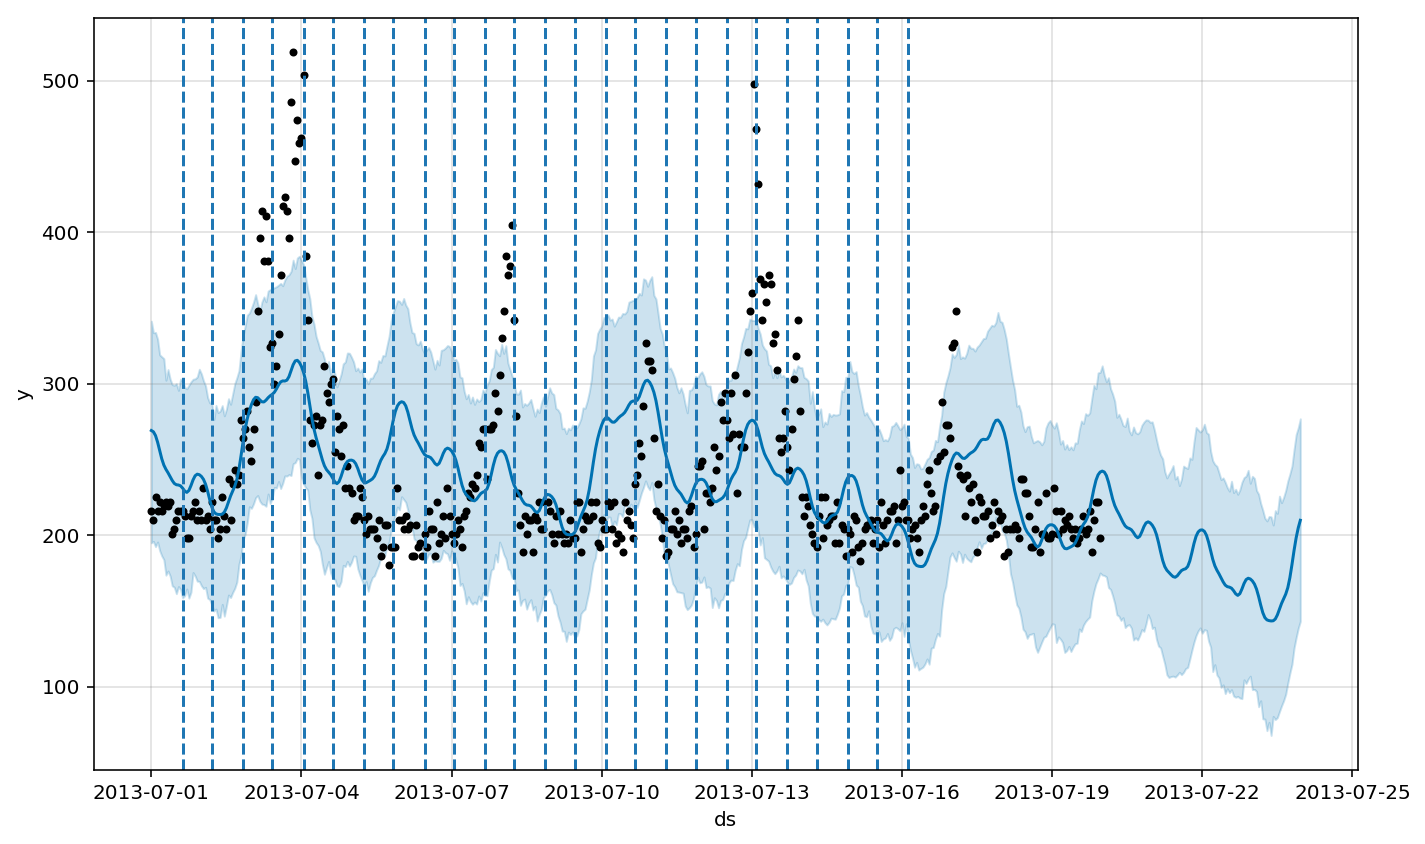

In [81]:
#les points de changements de la tendance.
plt.figure(figsize=(20,15))
model.changepoints
figure = model.plot(forecast)
for changepoint in model.changepoints:
    plt.axvline(changepoint,ls='--')

In [68]:
model.seasonalities

OrderedDict([('yearly',
              {'period': 365.25,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None}),
             ('weekly',
              {'period': 7,
               'fourier_order': 3,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None}),
             ('daily',
              {'period': 1,
               'fourier_order': 4,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None})])

Nous travaillons maintenant sur le jeu de donnés d'Electrolysia

In [69]:
df2=pd.read_table("train.csv",sep = ',',header = 0)
df2.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


In [70]:
#on récupére que les 2 colonnes des dates et la consomation pour le 1er mois
data=df2[['datetime','electricity_consumption']][0:552]
data=data.rename(columns={'datetime': 'ds','electricity_consumption':'y'})
data.head()

,ds,y
0,2013-07-01 00:00:00,216.0
1,2013-07-01 01:00:00,210.0
2,2013-07-01 02:00:00,225.0
3,2013-07-01 03:00:00,216.0
4,2013-07-01 04:00:00,222.0


In [71]:
#on prend les 20 premiers jours pour l'entrainement du modéle et essayons de prédire les 4 suivants.
train__size=456
train=data[:train__size]
test=data[train__size:]
test.head()

,ds,y
456,2013-07-20 00:00:00,195.0
457,2013-07-20 01:00:00,189.0
458,2013-07-20 02:00:00,216.0
459,2013-07-20 03:00:00,192.0
460,2013-07-20 04:00:00,207.0


In [72]:
#on ajuste le modéle, par défaut le modéle est additive. 
model =Prophet()
model.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [73]:
#on définit le nombre de période au quelle on veut faire de la prédiction et on précise la fréquence:
future = model.make_future_dataframe(periods=96, freq='H')

#on applique le modéle:
forecast = model.predict(future)

In [74]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-07-01 00:00:00,261.200003,194.943646,341.274105,261.200003,261.200003,7.898585,7.898585,7.898585,15.645375,15.645375,15.645375,-7.746790,-7.746790,-7.746790,0.0,0.0,0.0,269.098588
1,2013-07-01 01:00:00,261.127547,195.902569,333.656324,261.127547,261.127547,7.130644,7.130644,7.130644,14.753715,14.753715,14.753715,-7.623071,-7.623071,-7.623071,0.0,0.0,0.0,268.258190
2,2013-07-01 02:00:00,261.055091,192.447585,333.836659,261.055091,261.055091,4.718200,4.718200,4.718200,12.360998,12.360998,12.360998,-7.642798,-7.642798,-7.642798,0.0,0.0,0.0,265.773291
3,2013-07-01 03:00:00,260.982635,195.506573,329.387391,260.982635,260.982635,0.418610,0.418610,0.418610,8.234209,8.234209,8.234209,-7.815598,-7.815598,-7.815598,0.0,0.0,0.0,261.401245
4,2013-07-01 04:00:00,260.910179,189.791553,319.071338,260.910179,260.910179,-5.086860,-5.086860,-5.086860,3.061750,3.061750,3.061750,-8.148610,-8.148610,-8.148610,0.0,0.0,0.0,255.823319
5,2013-07-01 05:00:00,260.837723,186.320357,317.790297,260.837723,260.837723,-10.425917,-10.425917,-10.425917,-1.779574,-1.779574,-1.779574,-8.646343,-8.646343,-8.646343,0.0,0.0,0.0,250.411807
6,2013-07-01 06:00:00,260.765268,183.809704,316.587254,260.765268,260.765268,-14.493127,-14.493127,-14.493127,-5.182558,-5.182558,-5.182558,-9.310569,-9.310569,-9.310569,0.0,0.0,0.0,246.272141
7,2013-07-01 07:00:00,260.692812,173.611179,302.303383,260.692812,260.692812,-17.220698,-17.220698,-17.220698,-7.080448,-7.080448,-7.080448,-10.140249,-10.140249,-10.140249,0.0,0.0,0.0,243.472114
8,2013-07-01 08:00:00,260.620356,176.352319,309.345524,260.620356,260.620356,-19.410675,-19.410675,-19.410675,-8.279170,-8.279170,-8.279170,-11.131505,-11.131505,-11.131505,0.0,0.0,0.0,241.209681
9,2013-07-01 09:00:00,260.547900,173.083212,303.120184,260.547900,260.547900,-21.803796,-21.803796,-21.803796,-9.526177,-9.526177,-9.526177,-12.277619,-12.277619,-12.277619,0.0,0.0,0.0,238.744104


In [75]:
#on récupére que les valeurs de la consomation 'yhat' pour les comparer avec les valeurs de test.
Prediction=forecast[['yhat']].values[train__size:]
reel=test[['y']].values
#les valeurs qu'on vient de récupérer sont nd-array

#transformer nd-array en array
Prediction=np.ravel(Prediction)
reels=np.ravel(reel)

#Mettre les données sous forme serie temporelles pour les visualiser
Predictions=pd.Series(Prediction,index=pd.date_range('2013-07-20 00:00:00',periods=96,freq='h'))
Real=pd.Series(reels,index=pd.date_range('2013-07-20 00:00:00',periods=96,freq='h'))

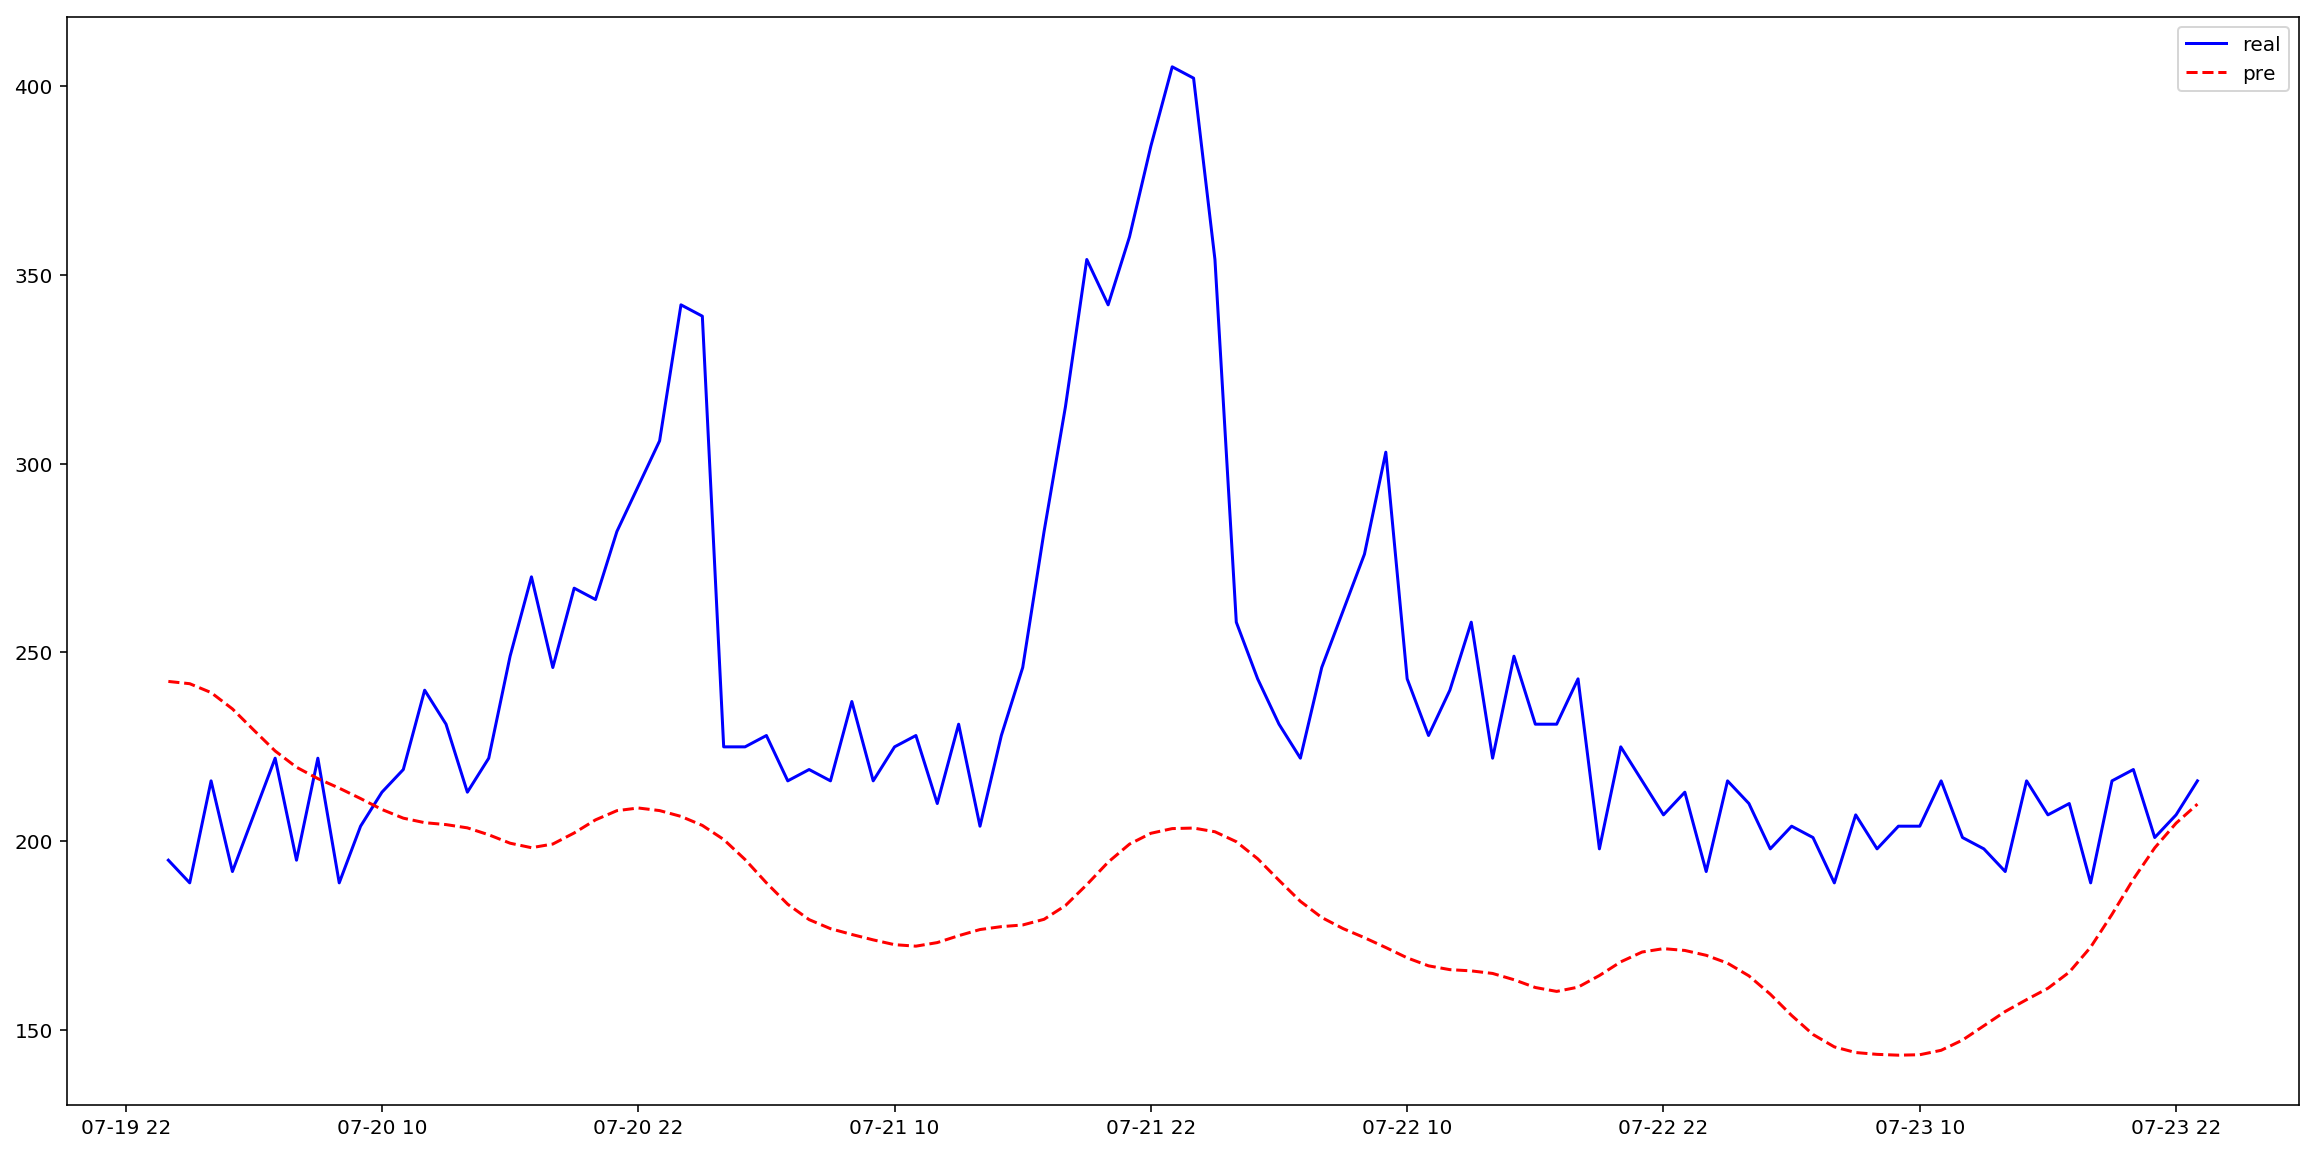

In [76]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(Real, '-b', label='real')
ax.plot(Predictions, '--r', label='pre')

leg = ax.legend();


plt.savefig('lolo.png')

Apparement le résulta n'est pas bon, ce qui est compatible avec ce qu'on a cité dans le rapport, le facebbok prophet a besoin au moins d'une année de données pour l'ajuster et avoir un résultat acceptable.
A ce point, ce n'est pas utile à continuer d'étudier les différentes composantes du modéle.